# Conditional Image Generation

GANs are trained in a completely unsupervised and uncondional method. What if we want to generate a specfic type of image from the generator? Conditional GANs are those Generative Adversarial Networks (GANs) where we condition the generator on something during the generation process. We will implementa conditonal here, on CIFAR-10 dataset.

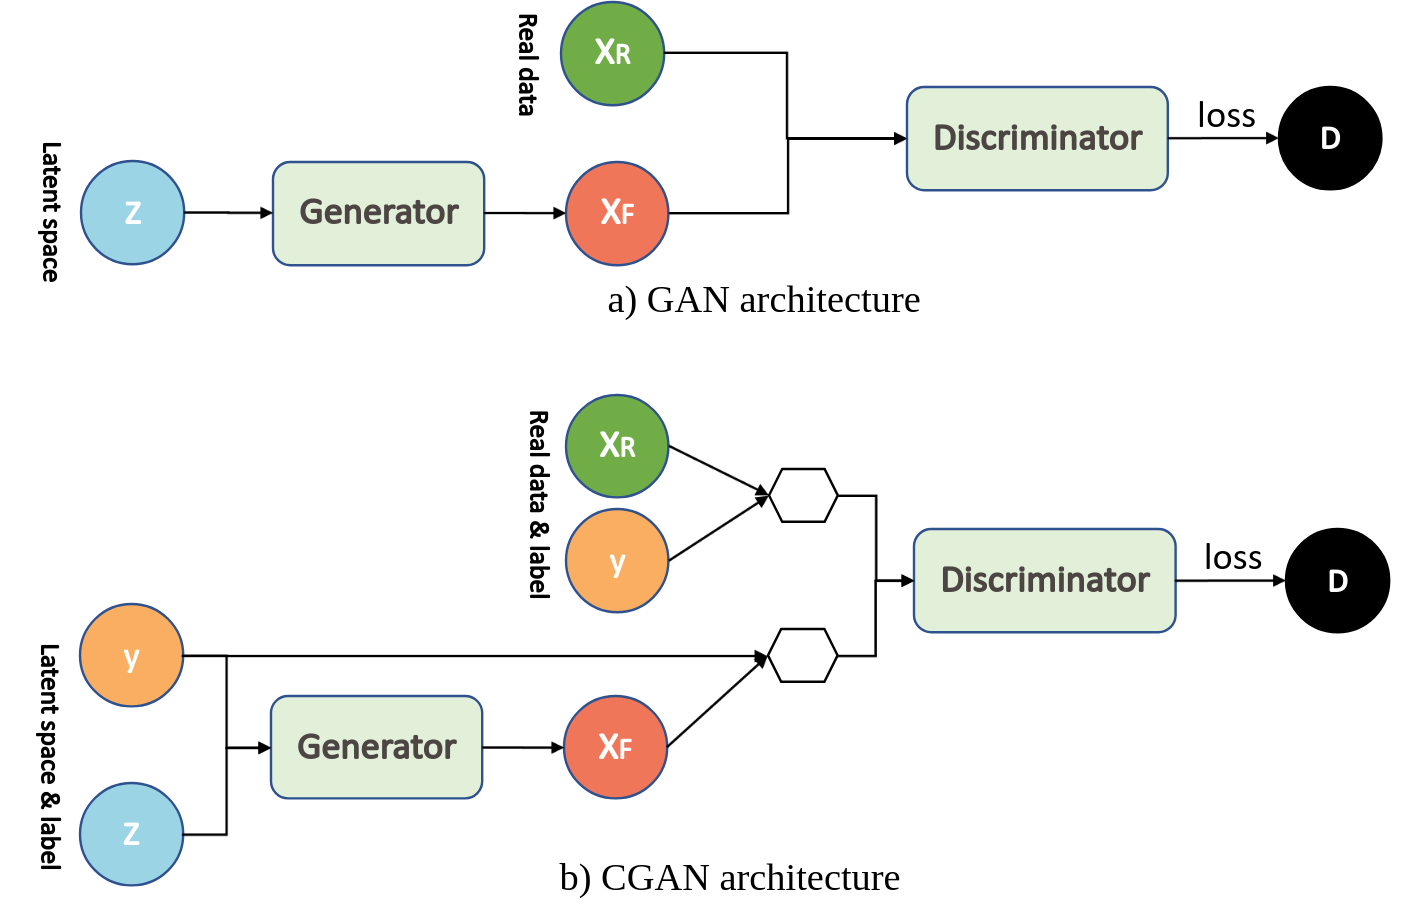

<p align = "center">
Fig.1 - GAN vs. CGAN 
(<a href="https://itchef.ru/articles/341494/">
source
</a>)
</p>

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Lambda
from torchsummary import summary
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
import numpy as np
from PIL import Image

In [ ]:
EPOCHS = 60
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
Z = 100

In [ ]:
transform_steps = Compose([
            ToTensor(),
            Lambda(lambda t: (t * 2) - 1)
])

In [ ]:
# We will be using the mnist digit data.
cifar_dataset = datasets.CIFAR10(root="cifar_data/", download=True, transform=transform_steps)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar_data/cifar-10-python.tar.gz to cifar_data/


In [ ]:
# Initializing pytorch dataloader
train_dataloader = DataLoader(cifar_dataset, batch_size=BATCH_SIZE, shuffle=True)

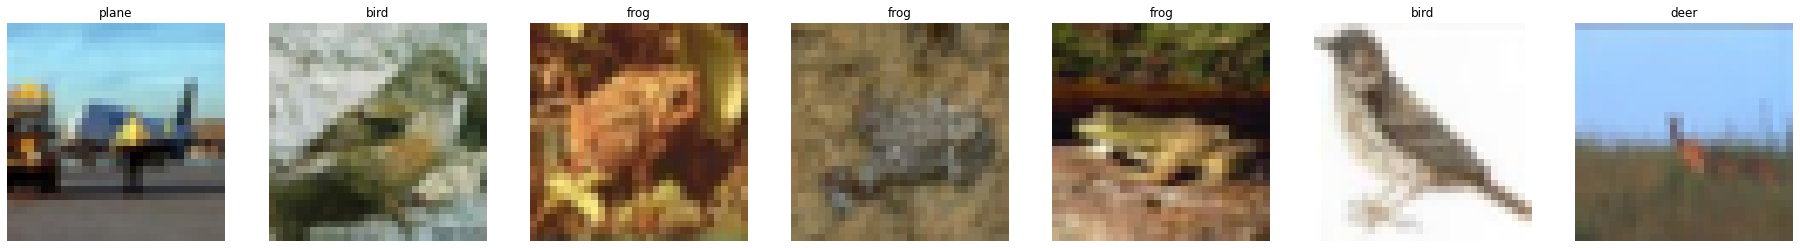

In [ ]:
# Visualizing some sample images
figure = plt.figure(figsize=(32, 32))
cols, rows = 7, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(cifar_dataset), size=(1,)).item()
    img, label = cifar_dataset[sample_idx]
    img = (img/2)+0.5
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.permute((1,2,0)))
plt.show()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

GANs consist of two separate models: generator and discriminator. The generator will take random noise as input and output an image. The discriminator will take an image as input and predict whether its fake or real.

GANs are notoriously hard to train. Considering this, the authors make a few recommendations to make the training more tractable.
 - Initialize weights from N(0, 0.02)
 - Use Tanh as activation
 - Use ADAM as optimzer and set beta1=0.5

We will be using these here.

In [ ]:
class Reshape(nn.Module):
  """A custom reshape layer."""
  def __init__(self, shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.view(*self.shape)

class Print_shape(nn.Module):
  """A custom reshape layer."""
  def __init__(self):
    super().__init__()

  def forward(self, x):
    print(x.shape)
    return x


def weights_init(m):
    """Reinitialize model weights. GAN authors recommend them to be sampled from N(0,0.2)"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
  """Generator model"""
  def __init__(self, z):
    super(Generator, self).__init__()
    self.z = z
    self.gen_model = nn.Sequential(
        nn.Linear(z + 50, 512),
        nn.BatchNorm1d(512),
        nn.LeakyReLU(),

        nn.Linear(512, 512 * 4 * 4),
        nn.BatchNorm1d(512 * 4 * 4),
        nn.LeakyReLU(),

        Reshape((-1,512,4,4)),
        # Print_shape(),

        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(),

        nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),
        # Print_shape(),

        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),

        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),
        # Print_shape(),

        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),

        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        # Print_shape(),

        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1),
        nn.Tanh(),
        # Print_shape(),
    )

    self.condition_layer = nn.Linear(10, 50)
  
  def forward(self, x, condition):
    condition = nn.functional.one_hot(condition, num_classes = 10).type(x.dtype).to(x.device)
    condition = nn.functional.leaky_relu(self.condition_layer(condition))

    x = torch.cat([x,condition], 1)

    x = self.gen_model(x)
    return x


class Discriminator(nn.Module):
  """Discriminator model"""
  def __init__(self):
    super(Discriminator, self).__init__()
    self.disc_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=2, padding=2),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),

        nn.Flatten(1,-1),
        # nn.Linear(256 * 4 * 4, 128),
        # nn.BatchNorm1d(128),
        # nn.LeakyReLU(),
        
        # nn.Linear(128, 1),
        # nn.Sigmoid(),
    )

    self.condition_layer = nn.Linear(10, 50)
    # self.reshape_layer = Reshape((-1,1,32,32))
    self.layer_1 = nn.Linear(256 * 4 * 4 + 50, 256)
    self.layer_1_b = nn.BatchNorm1d(256)
    self.layer_1_a = nn.LeakyReLU()

    self.layer_2 = nn.Linear(256, 128)
    self.layer_2_b = nn.BatchNorm1d(128)
    self.layer_2_a = nn.LeakyReLU()
    
    self.layer_3 = nn.Linear(128, 1)
    self.layer_3_a = nn.Sigmoid()

  def forward(self, x, condition):
    condition = nn.functional.one_hot(condition, num_classes = 10).type(x.dtype).to(x.device)
    condition = nn.functional.leaky_relu(self.condition_layer(condition))
    # condition = self.reshape_layer(condition)



    x = self.disc_model(x)
    x = torch.cat([x,condition], 1)
    x = self.layer_1_a(self.layer_1_b(self.layer_1(x)))
    x = self.layer_2_a(self.layer_2_b(self.layer_2(x)))
    x = self.layer_3_a(self.layer_3(x))
    return x


generator = Generator(z=Z)
generator.apply(weights_init)
generator.to(device)

discriminator = Discriminator()
discriminator.apply(weights_init)
discriminator.to(device)

Discriminator(
  (disc_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (condition_layer): Linear(in_features=10, out_features=50, bias=True)
  (layer_1): Linear(in_features=4146, out_features=256, bias=True)
  (layer_1_b): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_1_a): LeakyReLU(negative_slope=0.01)
  (layer_2): L

For training, we have to train the two models alternatively to each other. The discriminators goal is to maxime the liklihood of correctly predicting between real and fake images. So, the overall goal of discriminator is to mamximize the following: 
$$log(D(x)) + log(1-D(G(z)))$$

The generators goal is to foole the discriminator suc that it predicts its generated images as real. So, the goal of generator is to maximize the following:
$$log(D(G(z)))$$

We will alternatively train both the discriminator and the generator.

In [ ]:
# Defining the optimizer and loss function here
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
loss_fn = nn.BCELoss()

In [ ]:
real_label = 1
fake_label = 0

In [ ]:
# Helper function to display results
def display_image_grid(images, labels, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im, l in zip(grid, images, labels):
        ax.imshow(im.permute(1,2,0))

        ax.axis("off")
        ax.set_title(classes[l])
    
    plt.suptitle(title_text, fontsize=20)
    plt.show()

In [ ]:
sample_noise = torch.randn(10, Z).to(device)
sample_labels = torch.arange(10).to(device)

discriminator.train()
generator.train()

# Training loop
for i in range(1,EPOCHS+1):
  pbar = tqdm(train_dataloader)
  for b, data in enumerate(pbar):
    # Every data instance is an input + label pair. We don't need the label
    inputs, condition = data
    # print(condition, condition.shape)
    inputs = inputs.to(device)
    inputs = (inputs - 0.5) * 2 # setting data range to [-1,1]

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################

    ## Train with all-real batch
    discriminator.zero_grad()
    # Set up labels
    label = torch.full((inputs.shape[0],1), real_label, dtype=torch.float, device=device)
    # Forward pass real batch through D
    output = discriminator(inputs, condition)
    # Calculate loss on all-real batch
    errD_real = loss_fn(output, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()
    D_x = output.mean().item()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(inputs.shape[0], Z, device=device)
    # Generate fake image batch with G
    fake = generator(noise, condition)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output = discriminator(fake.detach(), condition)
    # Calculate D's loss on the all-fake batch
    errD_fake = loss_fn(output, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizer_disc.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    generator.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = discriminator(fake, condition)
    # Calculate G's loss based on this output
    errG = loss_fn(output, label)
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizer_gen.step()

    pbar.set_description(f"Epoch {i}/{EPOCHS}: ")
    pbar.set_postfix({"generator_loss": errG.item(), "discriminator_loss": errD.item(), "D(x)": D_x, "D(G(z1))": D_G_z1, "D(G(z2))": D_G_z2})

  with torch.no_grad():
    generations = generator(sample_noise, sample_labels).cpu()
    generations = (generations + 1) / 2 # setting generations range to [0,1] 
  display_image_grid(generations.squeeze(1), sample_labels, 1, 10, f"generated_images at epoch {i}")


In [ ]:
# Set the generator to eval state
generator.eval()

Generator(
  (gen_model): Sequential(
    (0): Linear(in_features=150, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=512, out_features=8192, bias=True)
    (4): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Reshape()
    (7): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps

### Generation through Condional GANs

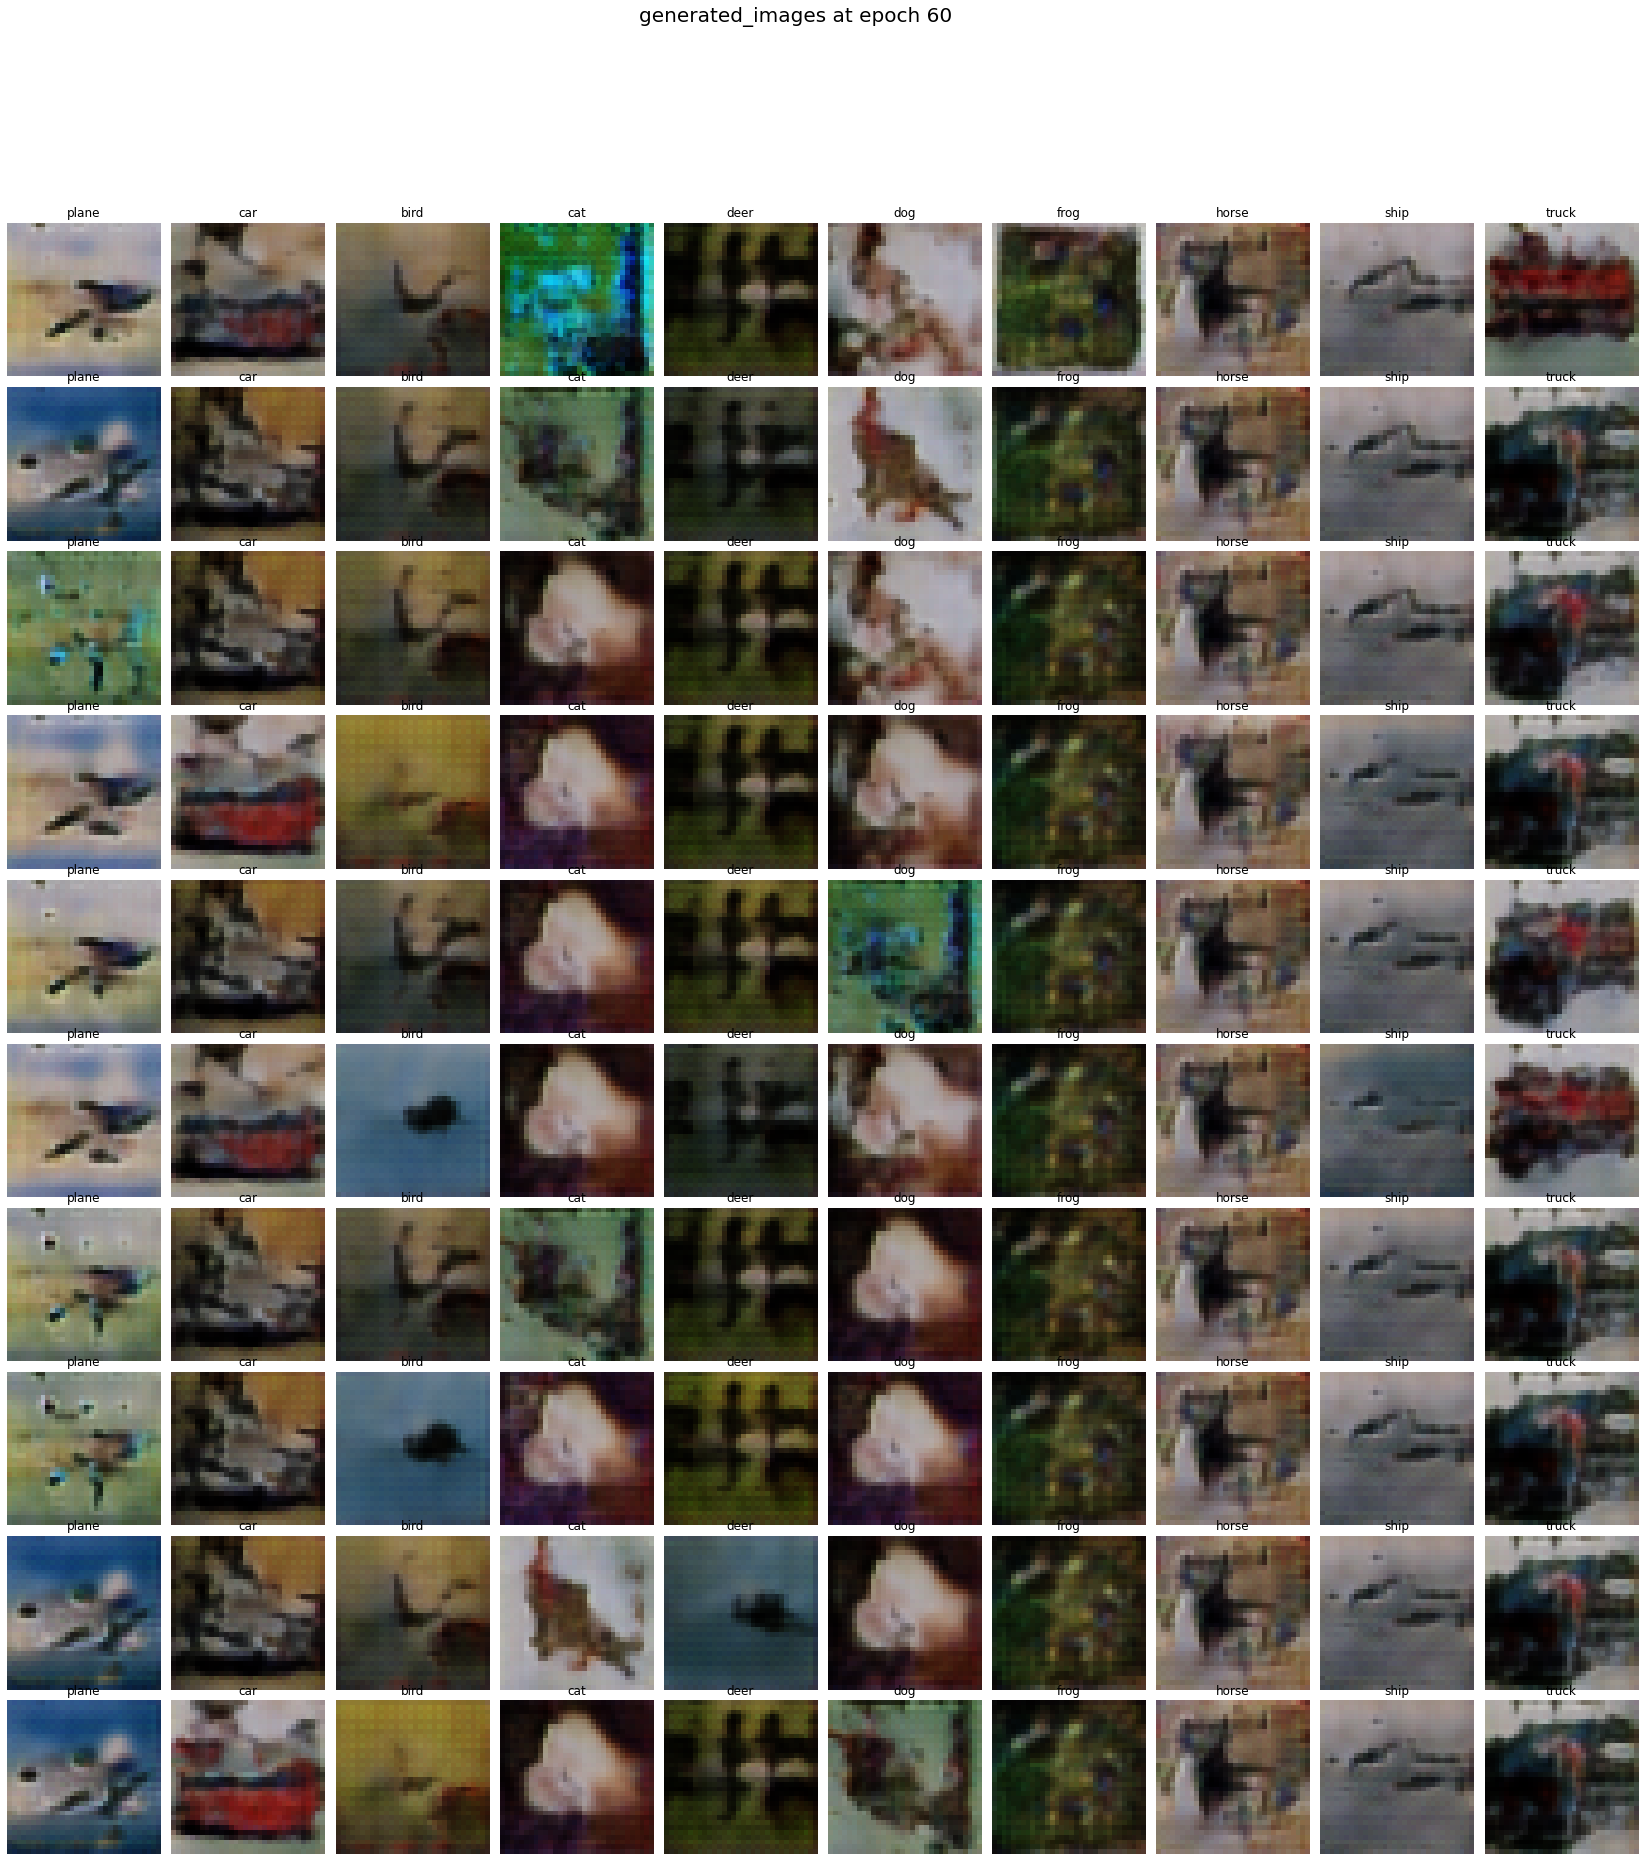

In [ ]:
# Now we will try some actual generation. We will sample the encodings randomly and then pass them through decoder

rows, cols = 10, 10
sample_noise = torch.randn(rows*cols, Z).to(device)
sample_labels = torch.arange(10).repeat(10)
# with torch.no_grad():
#   generations = generator(sample_noise).cpu()
#   generations = (generations + 1) / 2 # setting generations range to [0,1] 
# display_image_grid(generations.squeeze(1), rows, cols, "generated_images")

with torch.no_grad():
  generations = generator(sample_noise, sample_labels).cpu()
  generations = (generations + 1) / 2 # setting generations range to [0,1] 
display_image_grid(generations.squeeze(1), sample_labels, 10, 10, f"generated_images")